In [2]:
import numpy as np
from numpy import asarray
from PIL import Image as im
import os
import math
import cv2 as cv
from tqdm import tqdm
import typing as tp

In [4]:
data_path = r"WarpDoc"

labels = os.listdir(data_path)
classes = os.listdir(os.path.join(data_path,labels[0]))

#### Importing image

In [5]:
img = im.open(r"WarpDoc\distorted\curved\0082.jpg")
img = asarray(img)
img.shape

(1772, 1328, 3)

#### Converting grayscale

In [ ]:
grayscale = np.uint8(0.2126 * img[:,:,0] + 0.7152 * img[:,:,1] + 0.0722 * img[:,:,2])

In [ ]:
blurred = cv.GaussianBlur(grayscale, (5, 5), 1.4)
edges = cv.Canny(blurred, 50, 150)

In [19]:
import torch

In [20]:
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

In [21]:
torch.cuda

<module 'torch.cuda' from 'c:\\Users\\alkan\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\torch\\cuda\\__init__.py'>

In [22]:
rho = 9
theta = 0.261
threshold = 101

def hough_lines(edges: np.ndarray, threshold: float, min_theta: float, max_theta: float) -> np.ndarray:
    # Initialize the counter matrix in polar coordinates
    diagonal = np.sqrt(img.shape[0]**2 + img.shape[1]**2)

    # Compute the values for the thetas and the rhos
    theta_angles = np.arange(min_theta, max_theta, theta)
    rho_values = np.arange(-diagonal, diagonal, rho)
    # Compute the dimension of the accumulator matrix
    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    accumulator = np.zeros([num_rhos, num_thetas])
    print('Accumulator shape (rhos x thetas):' + str(accumulator.shape))

     # Pre-compute sin and cos
    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)
    
    # Consider edges only
    xs, ys = np.where(edges > 0)
    
    for x,y in zip(xs,ys):
        for t in range(num_thetas):
            # compute the rhos for the given point for each theta
            current_rho = x * coss[t] + y * sins[t]
            # for each rho, compute the closest rho among the rho_values below it
            # the index corresponding to that rho is the one we will increase
            rho_pos = np.where(current_rho > rho_values)[0][-1]
            #rho_pos = np.argmin(np.abs(current_rho - rho_values))
            accumulator[rho_pos, t] += 1
     # Take the polar coordinates most matched
    final_rho_index, final_theta_index = np.where(accumulator > threshold)
    final_rho = rho_values[final_rho_index]    
    final_theta = theta_angles[final_theta_index]
    
    polar_coordinates = np.vstack([final_rho, final_theta]).T
    return polar_coordinates

In [23]:
class HoughTransform():

    def __init__(self,threshold = 2600,theta_steps = 1):
        self.theta_steps = theta_steps
        self.threshold = threshold
        pass

    def create_space(self,img_array):
        x,y=img_array.shape
        rho_max = round(math.sqrt(math.pow(x,2)+math.pow(y,2)))
        return np.zeros((180,2*rho_max)),rho_max
    
    def calc_space(self, img_array):
        img_space, rho_max = self.create_space(img_array)

        img_tensor = torch.tensor(img_array, dtype=torch.float32, device=device)

        h, w = img_tensor.shape

        x_indices = torch.arange(h, dtype=torch.float32, device=device).view(h, 1).expand(h, w)
        y_indices = torch.arange(w, dtype=torch.float32, device=device).view(1, w).expand(h, w)

        theta_range = torch.deg2rad(torch.arange(0, 180, self.theta_steps, dtype=torch.float32, device=device))

        rho_values = (x_indices.unsqueeze(-1) * torch.cos(theta_range) + 
                    y_indices.unsqueeze(-1) * torch.sin(theta_range)).round().long()

        rho_values += rho_max

        img_space_tensor = torch.tensor(img_space, dtype=torch.long, device=device)

        for i, theta in enumerate(theta_range):
            img_space_tensor[i].index_add_(0, rho_values[:, :, i].flatten(), torch.ones_like(rho_values[:, :, i], device=device).flatten())

        return img_space_tensor.cpu().numpy() 
            
    def draw_edges(self,img_array):
        img_space = self.calc_space(img_array)
        theta_rho = []
        lines_array = np.zeros(img_array.shape)

        print(img_space.max())
        draw_line = np.zeros_like(img_array)

        for i in tqdm(range(img_space.shape[0])):
            for j in range(img_space.shape[1]):
                if img_space[i,j]>self.threshold:
                    theta_rho.append((i,j))
        for line in tqdm(theta_rho):
            theta ,rho= line
            theta_rad = math.radians(theta)            
            # Doğruyu çizmek için başlangıç ve bitiş noktalarını belirle
            a = np.cos(theta_rad)
            b = np.sin(theta_rad)
            
            x0 = a * rho
            y0 = b * rho
            
            # Ekran sınırlarını aşmamak için uç noktaları belirle
            x_max = img_array.shape[1]
            y_max = img_array.shape[0]

            x1 = int(x0 + x_max * (-b))
            y1 = int(y0 + y_max * (a))
            x2 = int(x0 - x_max * (-b))
            y2 = int(y0 - y_max * (a))
            
        # Çizgiyi resme ekle
            draw_line = cv2.line(draw_line, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Sonucu göster
        cv2.imshow("Detected Lines", draw_line)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [24]:
transformer = HoughTransform()
transformer.draw_edges(edges)

2656


  0%|          | 0/293 [00:00<?, ?it/s]


NameError: name 'cv2' is not defined

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    ''' A function for creating a Hough Accumulator for lines in an image. '''
    height, width = img.shape
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) 
    rhos = np.arange(-img_diagonal, img_diagonal + rho_resolution, rho_resolution)
    thetas = np.deg2rad(np.arange(0, 180, theta_resolution))

    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) 

    # x ve y koordinatlarını tekrar kullanarak matris haline getiriyoruz
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)

    # Her piksel için (x, y) koordinatlarını tüm açılarla çarpıp rho değerlerini hesapla
    rho_values = (np.outer(x_idxs, cos_thetas) + np.outer(y_idxs, sin_thetas)) + img_diagonal

    # rho indexlerini hesapla
    rho_idxs = (rho_values / rho_resolution).astype(int)

    # Hough oylama matrisi (accumulator) için indeksleri güncelle
    np.add.at(accumulator, (rho_idxs, np.arange(len(thetas))), 1)

    return accumulator, rhos, thetas


# This is a simple peaks function that just finds the indicies of the number
# of maximum values equal to num_peaks.  You have to be careful here though, if
# there's any noise in the image it will like create a 'pocket' of local maxima
# values.  This function ignores this and in turn has the tendancy to return
# multiple lines along an actual line in the image.
def hough_simple_peaks(H, num_peaks):
    ''' A function that returns the number of indicies = num_peaks of the
        accumulator array H that correspond to local maxima. '''
    indices =  np.argpartition(H.flatten(), -2)[-num_peaks:]
    return np.vstack(np.unravel_index(indices, H.shape)).T


# This more advance Hough peaks funciton has threshold and nhood_size arguments
# threshold will threshold the peak values to be above this value if supplied,
# where as nhood_size will surpress the surrounding pixels centered around
# the local maximum after that value has been assigned as a peak.  This will
# force the algorithm to look eslwhere after it's already selected a point from
# a 'pocket' of local maxima.
def hough_peaks(H, num_peaks, threshold=0, nhood_size=3):
    ''' A function that returns the indicies of the accumulator array H that
        correspond to a local maxima.  If threshold is active all values less
        than this value will be ignored, if neighborhood_size is greater than
        (1, 1) this number of indicies around the maximum will be surpessed. '''
    # loop through number of peaks to identify
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        indicies.append(H1_idx)

        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values

        min_x = max(0,idx_x-(nhood_size//2))
        max_x = min( H.shape[1],idx_x + (nhood_size//2) + 1)

        min_y = max(0,idx_y-(nhood_size//2))
        max_y = min( H.shape[0],idx_y + (nhood_size//2) + 1)

        # bound each index by the neighborhood size and set all values to 0
        H1[min_y:max_y, min_x:max_x] = 0
        
        # Koordinat dizileri oluştur
        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)

        # Kenar maskelerini oluştur
        x_mask = (x_range == min_x) | (x_range == max_x - 1)
        y_mask = (y_range == min_y) | (y_range == max_y - 1)

        # H matrisinde kenarları 255 olarak güncelle
        H[np.ix_(y_range, x_range)] = np.where(
            np.outer(y_mask, np.ones_like(x_range)) | np.outer(np.ones_like(y_range), x_mask), 
            255, 
            H[np.ix_(y_range, x_range)]
        )

    # return the indicies and the original Hough space with selected points
    return np.array(indicies), H

# a simple funciton used to plot a Hough Accumulator
def plot_hough_acc(H, plot_title='Hough Accumulator Plot'):
    ''' A function that plot a Hough Space using Matplotlib. '''
    plt.figure(figsize=(20, 20))
    	
    plt.imshow(H, cmap='jet')

    plt.xlabel('Theta Direction')
    plt.ylabel('Rho Direction')
    plt.show()

# drawing the lines from the Hough Accumulatorlines using OpevCV cv2.line
def hough_lines_draw(img, indicies, rhos, thetas):
    ''' A function that takes indicies a rhos table and thetas table and draws
        lines on the input images that correspond to these values. '''
    copy = img.copy()
    height = copy.shape[0]
    width = copy.shape[1]

    for i in range(len(indicies)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + width*(-b))
        y1 = int(y0 + height*(a))
        x2 = int(x0 - width*(-b))
        y2 = int(y0 - height*(a))

        copy = cv2.line(copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return copy

def dist_point_to_line_batch(points, rho, theta):
    """
    Calculate the distance from points to a line in polar form using vectorized operations.
    
    Args:
        points: Array of (x, y) points
        rho: Distance from origin
        theta: Angle in radians
    
    Returns:
        Array of distances from points to line
    """
    x = points[:, 0]
    y = points[:, 1]
    # Distance = |rho - x*cos(theta) - y*sin(theta)|
    return np.abs(rho - x * np.cos(theta) - y * np.sin(theta))

def ransac_line_filtering_optimized(edge_image, indices,rhos,thetas, distance_threshold=2.0, min_inliers=50, max_lines=None):
    """
    Apply RANSAC to filter out noise and find the best-fitting lines with vectorized operations.
    
    Args:
        edge_image: Binary edge image
        lines_with_votes: List of (rho, theta, votes) tuples from Hough transform
        distance_threshold: Maximum distance for a point to be considered an inlier
        min_inliers: Minimum number of inliers to consider a line valid
        max_lines: Maximum number of lines to return (None for no limit)
    
    Returns:
        best_lines: List of (rho, theta) tuples representing the best lines
    """
    # Get edge point coordinates
    y_idxs, x_idxs = np.nonzero(edge_image)
    edge_points = np.column_stack((x_idxs, y_idxs))
    
    best_lines = []
    remaining_points_mask = np.ones(len(edge_points), dtype=bool)
    # Process each candidate line in order of votes (strongest first)
    for i in range(len(indices)):
        # Skip if too few points remain
        if np.sum(remaining_points_mask) < min_inliers:
            break
        
        rho_idx, theta_idx = indices[i][0],indices[i][1]
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]

        # Get current remaining points
        current_points = edge_points[remaining_points_mask]
        
        # Calculate distances from all remaining points to the line
        distances = dist_point_to_line_batch(current_points, rho, theta)
        
        # Find inliers (points with distance <= threshold)
        inliers_mask = distances <= distance_threshold
        
        # If we found enough inliers, consider this a valid line
        if np.sum(inliers_mask) >= min_inliers:
            best_lines.append(i)
            
            # Update the remaining points mask
            # Convert local mask to global mask indices
            global_indices = np.where(remaining_points_mask)[0]
            remaining_points_mask[global_indices[inliers_mask]] = False
            
            # Stop if we've found enough lines
            if max_lines is not None and len(best_lines) >= max_lines:
                break
    
    return best_lines

In [3]:
img = im.open(r"WarpDoc\distorted\curved\0082.jpg")
img = asarray(img)
img.shape
grayscale = np.uint8(0.2126 * img[:,:,0] + 0.7152 * img[:,:,1] + 0.0722 * img[:,:,2])
blurred = cv.GaussianBlur(grayscale, (21, 21), 3.2)
edges = cv.Canny(blurred, 50, 150)

In [6]:
# run hough_lines_accumulator on the shapes canny_edges image
hough_space, rhos, thetas = hough_lines_acc(edges,theta_resolution=1,rho_resolution=1)
indicies, H = hough_peaks(hough_space, num_peaks=400) # find peaks

In [223]:
indicies.shape

(400, 2)

In [7]:
indicies_filter = ransac_line_filtering_optimized(edges, indicies, rhos, thetas, 80, 100)
filtered_indicies = np.array(indicies)[indicies_filter]

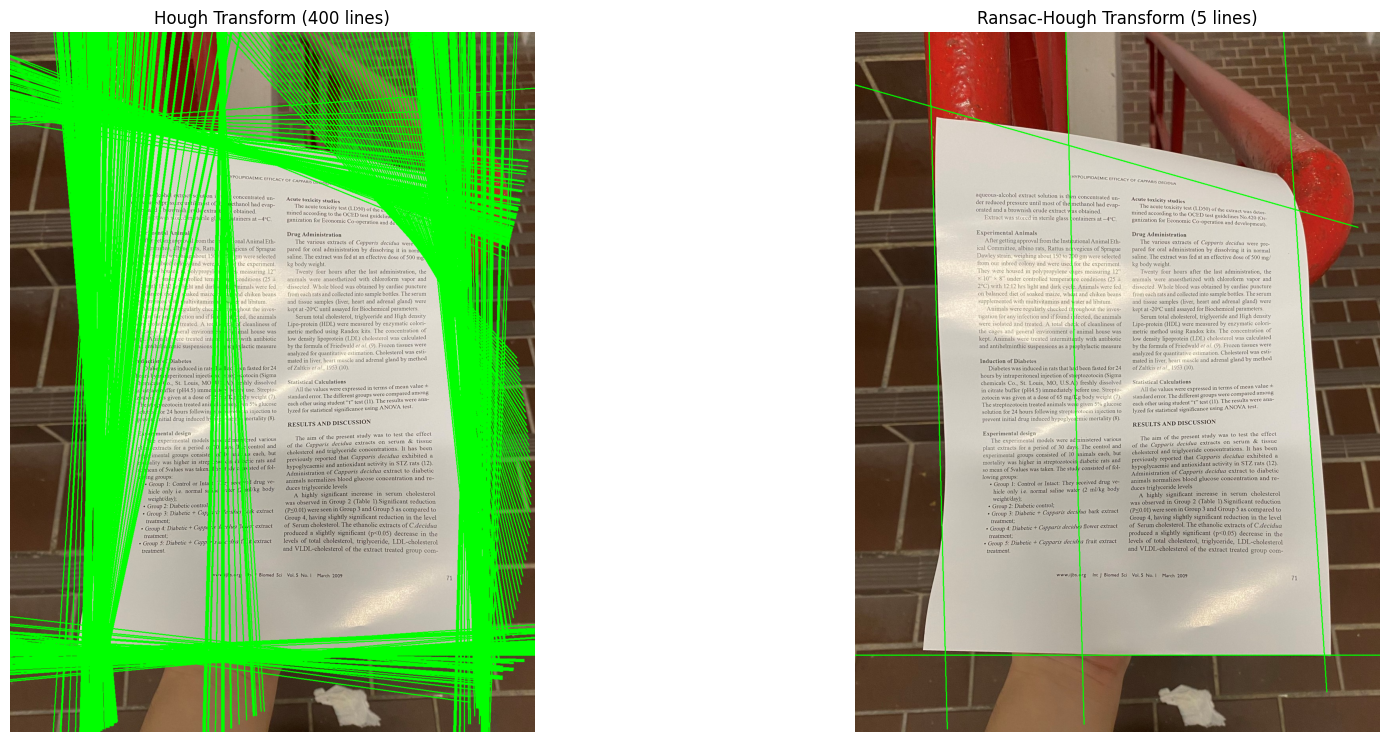

In [8]:
result = hough_lines_draw(img, indicies, rhos, thetas)
ransac_result = hough_lines_draw(img, filtered_indicies, rhos, thetas)

# Show image with manual Hough Transform Lines
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(result)
plt.title(f'Hough Transform ({len(indicies)} lines)')
plt.axis('off')

plt.subplot(222)
plt.imshow(ransac_result)
plt.title(f'Ransac-Hough Transform ({len(filtered_indicies)} lines)')
plt.axis('off')

plt.show()

### Segment lines according to their angles

In [ ]:
degree_mask = (indicies[:,1] >= 45) & (indicies[:,1] < 135)
degree_mask

array([ True, False,  True, False,  True, False, False, False, False,
       False, False,  True, False,  True,  True, False,  True, False,
       False,  True,  True,  True, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False,  True,
       False,  True, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False,  True,
        True, False, False, False,  True, False, False,  True, False,
       False, False,  True,  True,  True, False,  True, False,  True,
       False, False,  True,  True, False,  True, False,  True, False,
       False, False, False,  True, False, False, False, False,  True,
        True, False, False, False,  True,  True, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True,

In [54]:
indicies[degree_mask,:]

array([[3792,   90],
       [3778,   91],
       [2344,  102],
       [2373,  100],
       [2360,  101],
       [2394,   98],
       [3776,   91],
       [2402,   97],
       [2384,   99],
       [3773,   91],
       [3771,   92],
       [2408,   96],
       [3807,   89],
       [3767,   92],
       [2362,  101],
       [3769,   92],
       [2326,  103],
       [2386,   99],
       [3787,   90],
       [2396,   98],
       [2375,  100],
       [2382,  100],
       [3812,   89],
       [2399,   98],
       [3809,   89],
       [2413,   95],
       [2378,  100],
       [2388,   99],
       [3804,   89],
       [3765,   92],
       [3783,   90],
       [3785,   90],
       [2390,   99],
       [3795,   89],
       [3790,   90],
       [2329,  103],
       [3753,   92],
       [3821,   88],
       [2307,  104],
       [3760,   93],
       [3763,   93],
       [3802,   89],
       [3757,   93],
       [2380,  100],
       [3751,   92],
       [3781,   90],
       [3800,   89],
       [3814,

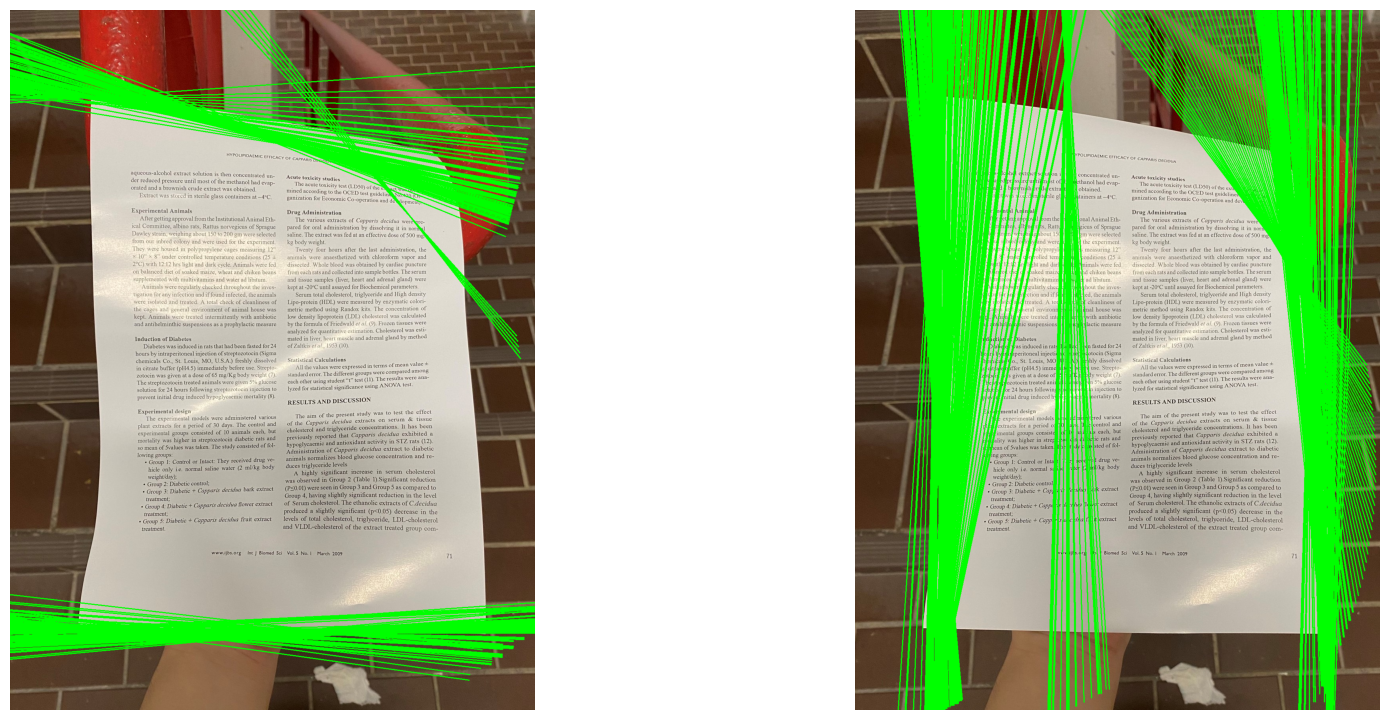

In [55]:
ransac_result_vertical = hough_lines_draw(img, indicies[degree_mask,:], rhos, thetas)
ransac_result_horizontal = hough_lines_draw(img, indicies[~degree_mask,:], rhos, thetas)

# Show image with manual Hough Transform Lines
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(ransac_result_vertical)
plt.axis('off')

plt.subplot(222)
plt.imshow(ransac_result_horizontal)
plt.axis('off')

plt.show()

In [58]:
def segment_by_angle(indices):
    degree_mask = (indices[:,1] >= 45) & (indices[:,1] < 135)
    vertical_lines = indices[degree_mask,:]
    horizontal_lines = indices[~degree_mask,:]      
    return vertical_lines, horizontal_lines

#### Intersect the lines

In [68]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return (x0, y0)

In [69]:
vertical,horizontal = segment_by_angle(filtered_indicies)

intersection_points = []

for i in range(len(vertical)):
    for j in range(len(horizontal)):
        line1 = (rhos[vertical[i][0]], thetas[vertical[i][1]])
        line2 = (rhos[horizontal[j][0]], thetas[horizontal[j][1]])
        inter = intersection(line1,line2)
        intersection_points.append(inter)
intersection_points

C:\Users\alkan\AppData\Local\Temp\ipykernel_13536\4739715.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x0, y0 = int(np.round(x0)), int(np.round(y0))


[(1224, 1577), (242, 1577), (588, 1577), (1118, 370), (193, 173), (542, 247)]

#### Choose corners from intersections

In [70]:

# Sort by x (left to right)
intersection_points = sorted(intersection_points, key=lambda p: p[0])

# Leftmost and rightmost points
left_points = intersection_points[:2]
right_points = intersection_points[-2:]

# Sort by y to separate top and bottom
left_points.sort(key=lambda p: p[1])  # Top-left, bottom-left
right_points.sort(key=lambda p: p[1])  # Top-right, bottom-right

top_left = left_points[0]
bottom_left = left_points[1]
top_right = right_points[0]
bottom_right = right_points[1]

#### Show corners on image

(np.float64(-0.5), np.float64(1327.5), np.float64(1771.5), np.float64(-0.5))

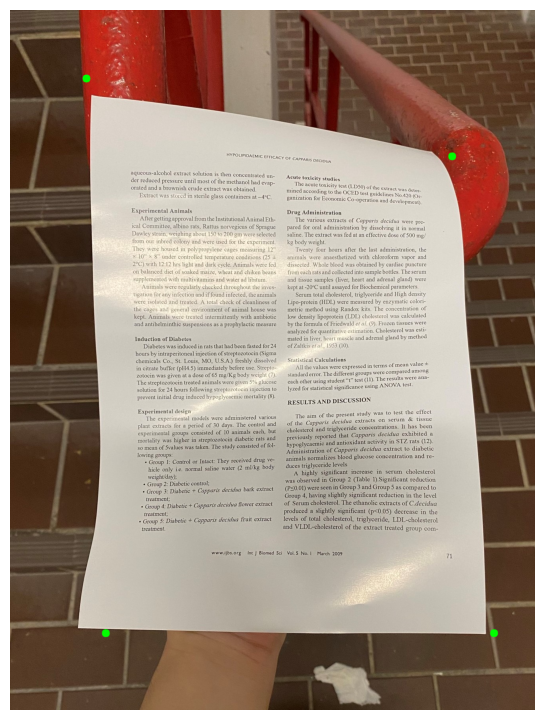

In [ ]:
dotted_image = img.copy()
dotted_image=cv2.circle(dotted_image, top_left, 10, (0, 255, 0), -1)
dotted_image=cv2.circle(dotted_image, bottom_left, 10, (0, 255, 0), -1)
dotted_image=cv2.circle(dotted_image, top_right, 10, (0, 255, 0), -1)
dotted_image=cv2.circle(dotted_image, bottom_right, 10, (0, 255, 0), -1)

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(dotted_image)
